In [1]:
from src.collectors import DataCollector

COLLECTOR_KWARGS = {'metric': 'minkowski', 'p': 1}
COLLECTOR = DataCollector(metric_kwargs=COLLECTOR_KWARGS)

EXPERIMENT='Minkowski-Even2'

NUM_EPOCHS = 5

In [2]:
# After https://pytorch.org/tutorials/beginner/introyt/trainingyt.html
# and https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#finetuning-the-convnet

from tqdm import tqdm

import torch


def train(model, loaders, criterion, optimizer, scheduler, num_epochs=5, device=torch.device('cpu')):
    model.to(device)
    
    losses = {}
    losses['train'], losses['valid'] = [], []
    accs = {}
    accs['train'], accs['valid'] = [], []

    for epoch in range(num_epochs):
        COLLECTOR.current_epoch = epoch

        train_loss, train_acc = one_epoch('train', model, loaders['train'], criterion, scheduler, optimizer, epoch, device)
        valid_loss, valid_acc = one_epoch('valid', model, loaders['valid'], criterion, scheduler, optimizer, epoch, device)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_acc}")
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {valid_loss:.4f}, Accuracy: {valid_acc}")
        
        losses['train'].append(train_loss)
        losses['valid'].append(valid_loss)
        accs['train'].append(train_acc)
        accs['valid'].append(valid_acc)
        
    return losses, accs

def one_epoch(phase, model, loader, criterion, scheduler, optimizer, epoch_idx, device):
    if phase == 'train':
        model.train()
    elif phase == 'valid':
        model.eval()
    else:
        raise ValueError(
            f"Phase {phase} is not a proper learning phase (use 'train' or 'valid')!")

    running_loss = 0.0
    running_corrects = 0
    dataset_size = 0

    for batch, (inputs, labels) in enumerate(tqdm(loader)):
        COLLECTOR.current_batch = batch
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            if phase == 'train':
                loss.backward()
                optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += float(torch.sum(predictions == labels.data).cpu().numpy())
        dataset_size += inputs.size(0)

        if phase == 'train' and scheduler is not None:
            scheduler.step()

    epoch_loss = running_loss / dataset_size
    epoch_acc = running_corrects / dataset_size

    return epoch_loss, epoch_acc

In [3]:
from src.modules.blocks import BasicBlock, Bottleneck, PlainBasicBlock, PlainBottleneck
from src.modules.models import ResNet


def resnet(version, in_channels, num_classes, plain=False, even=True):
    match version:
        case 18:
            layers = [2, 2, 2, 2]
            block = BasicBlock if not plain else PlainBasicBlock
        case 26:
            layers = [2, 2, 2, 2]
            block = Bottleneck if not plain else PlainBottleneck
        case 34:
            layers = [3, 4, 6, 3]
            block = BasicBlock if not plain else PlainBasicBlock
        case 50:
            layers = [3, 4, 6, 3]
            block = Bottleneck if not plain else PlainBottleneck
        case 68:
            layers = [3, 4, 23, 3]
            block = BasicBlock if not plain else PlainBasicBlock
        case 101:
            # layers = [3, 4, 23, 3]
            layers=[8,8,8,8]
            block = Bottleneck if not plain else PlainBottleneck        
        case _:
            raise ValueError(f'Version {version} is not a valid ResNet size.')
                
    model = ResNet(block=block, in_channels=in_channels, layers=layers, num_classes=num_classes, even=even)
    
    return model

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colorbar as colorbar


plt.style.use('ggplot')

def plot_differences(fig, axes, plain: bool, model: ResNet):
    title1, title2 = "Init differences", "Next differences"
    if plain:
        title1 += " [Plain]"
        title2 += " [Plain]"
        column = 0
    else:
        column = 1
        
    ax = axes[0][column]
    ax.set_title(title1)
    for depth, differences in COLLECTOR.init_differences.items():
        ax.plot(differences, label=f"depth = {depth}", color=plt.cm.coolwarm((depth-1) / model.max_depth))
    ax.set_xlabel('Batch number')
    ax.set_ylabel('Distance to initial state')
        
    ax = axes[1][column]
    ax.set_title(title2)
    for depth, differences in COLLECTOR.next_differences.items():
        ax.plot(differences, label=f"depth = {depth}", color=plt.cm.coolwarm((depth-1) / model.max_depth))
    ax.set_yscale('log')
    ax.set_xlabel('Batch number')
    ax.set_ylabel('Distance to previous state')
    
    if plain:
        for row in [0, 1]:
            cbar_ax = fig.add_axes([0.95, axes[row][0].get_position().y0, 0.02, axes[0][0].get_position().height])  # [left, bottom, width, height]
            cbar = colorbar.ColorbarBase(cbar_ax, cmap=plt.cm.coolwarm, orientation='vertical')
            cbar.set_ticks((np.linspace(1, model.max_depth, model.max_depth) - 1) / (model.max_depth - 1))
            cbar.set_ticklabels(np.linspace(1, model.max_depth, model.max_depth))
            cbar.set_label('Depth')

def plot_metrics(fig, axes, plain: bool, losses: dict, accuracies: dict):
    title1, title2 = "Losses", "Accuracies"
    if plain:
        title1 += " [Plain]"
        title2 += " [Plain]"
        column = 0
    else:
        column = 1
        
    ax = axes[0][column]
    ax.set_title(title1)
    ax.plot(range(1, len(losses['train']) + 1), losses['train'], label='Loss [train]')
    ax.plot(range(1, len(losses['valid']) + 1), losses['valid'], label='Loss [valid]')
    ax.set_xlabel('Epoch number')
    ax.set_ylabel('Loss')
    ax.legend(loc='upper right')
    
    ax = axes[1][column]
    ax.set_title(title2)
    ax.plot(range(1, len(accuracies['train']) + 1), accuracies['train'], label='Accuracy [train]')
    ax.plot(range(1, len(accuracies['valid']) + 1), accuracies['valid'], label='Accuracy [valid]')
    ax.set_xlabel('Epoch number')
    ax.set_ylabel('Accuracy')
    ax.legend(loc='upper left')
    
def share_y_axis(fig, axes):
    for row in range(len(axes)):
        miny, maxy = np.inf, 0
        for col in [0, 1]:
            for line in axes[row][col].lines:
                if line.get_ydata().min() < miny:
                    miny = line.get_ydata().min()
                if line.get_ydata().max() > maxy:
                    maxy = line.get_ydata().max()
        
        axes[row][0].set_ylim(miny, maxy)
        axes[row][1].set_ylim(miny, maxy)

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 10/10 [00:04<00:00,  2.21it/s]


Epoch [1/5], Loss: 2.3074, Accuracy: 0.10676
Epoch [1/5], Loss: 2.3185, Accuracy: 0.1063


100%|██████████| 10/10 [00:04<00:00,  2.23it/s]


Epoch [2/5], Loss: 2.2953, Accuracy: 0.11608
Epoch [2/5], Loss: 2.2911, Accuracy: 0.1185


100%|██████████| 10/10 [00:04<00:00,  2.23it/s]


Epoch [3/5], Loss: 2.2912, Accuracy: 0.11754
Epoch [3/5], Loss: 2.2991, Accuracy: 0.1211


100%|██████████| 10/10 [00:04<00:00,  2.23it/s]


Epoch [4/5], Loss: 2.2907, Accuracy: 0.11992
Epoch [4/5], Loss: 2.2951, Accuracy: 0.1134


100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


Epoch [5/5], Loss: 2.2898, Accuracy: 0.12022
Epoch [5/5], Loss: 2.2932, Accuracy: 0.1231


100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


Epoch [1/5], Loss: 2.0416, Accuracy: 0.38914
Epoch [1/5], Loss: 1.4409, Accuracy: 0.4779


100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


Epoch [2/5], Loss: 1.1745, Accuracy: 0.58146
Epoch [2/5], Loss: 1.2116, Accuracy: 0.5609


100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


Epoch [3/5], Loss: 0.9433, Accuracy: 0.6624
Epoch [3/5], Loss: 1.0036, Accuracy: 0.6471


100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


Epoch [4/5], Loss: 0.7620, Accuracy: 0.73016
Epoch [4/5], Loss: 1.1136, Accuracy: 0.6156


100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


Epoch [5/5], Loss: 0.6320, Accuracy: 0.778
Epoch [5/5], Loss: 0.9208, Accuracy: 0.6841


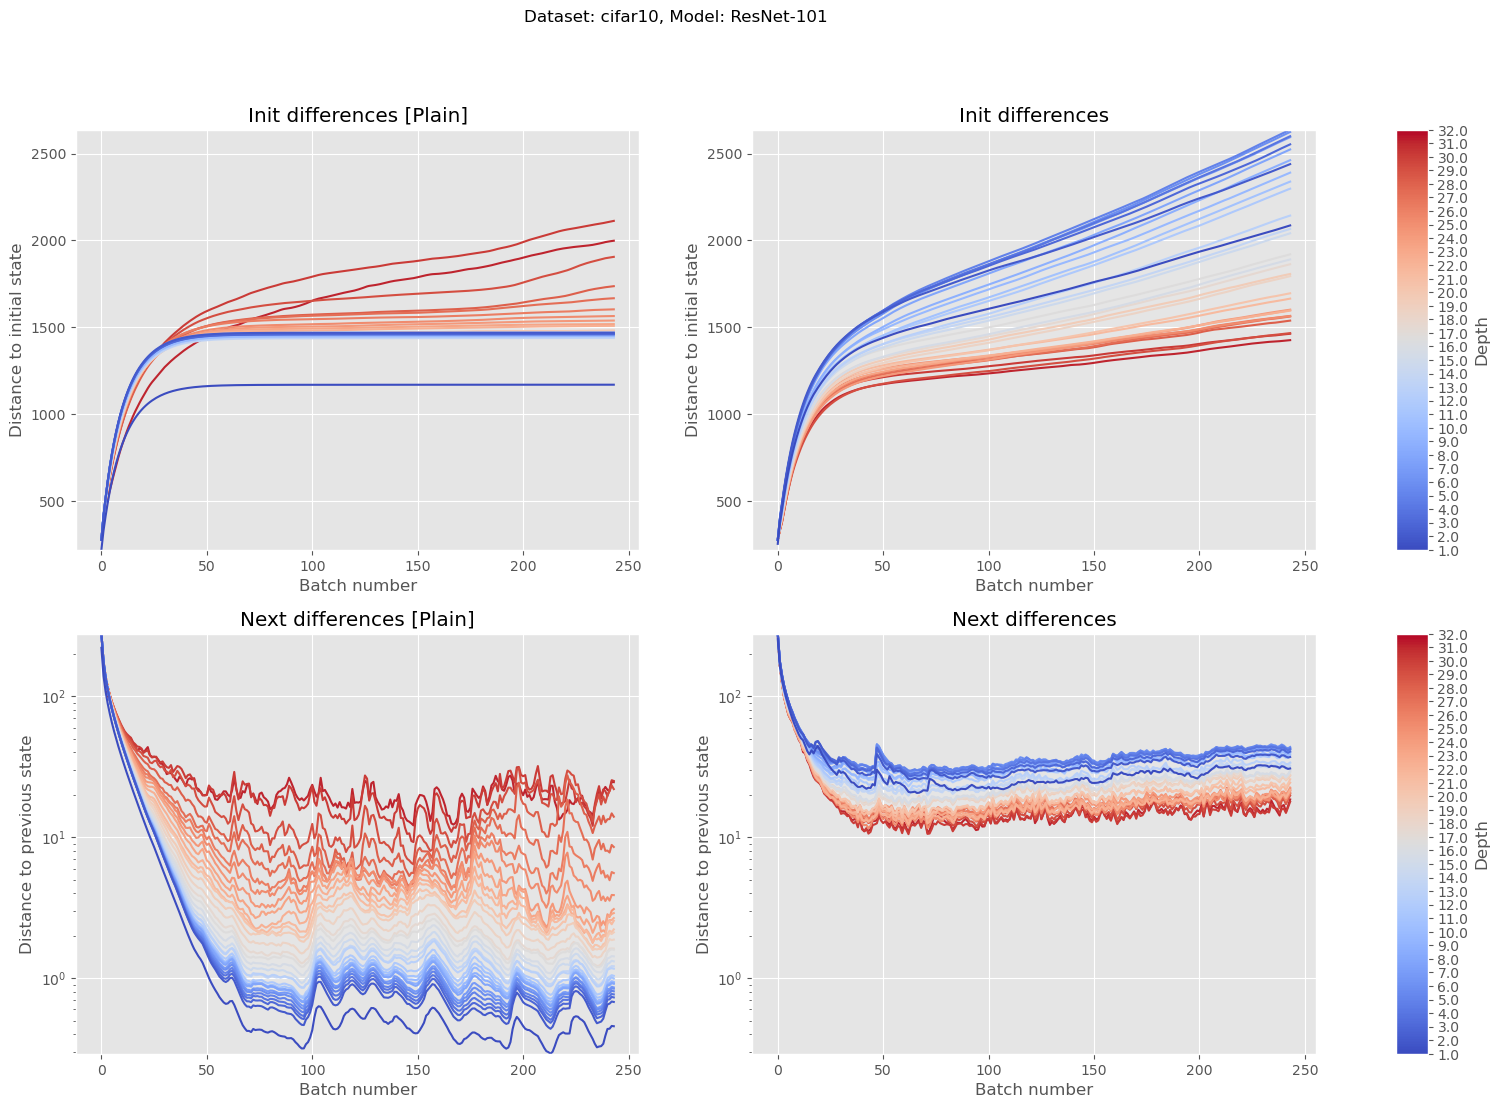

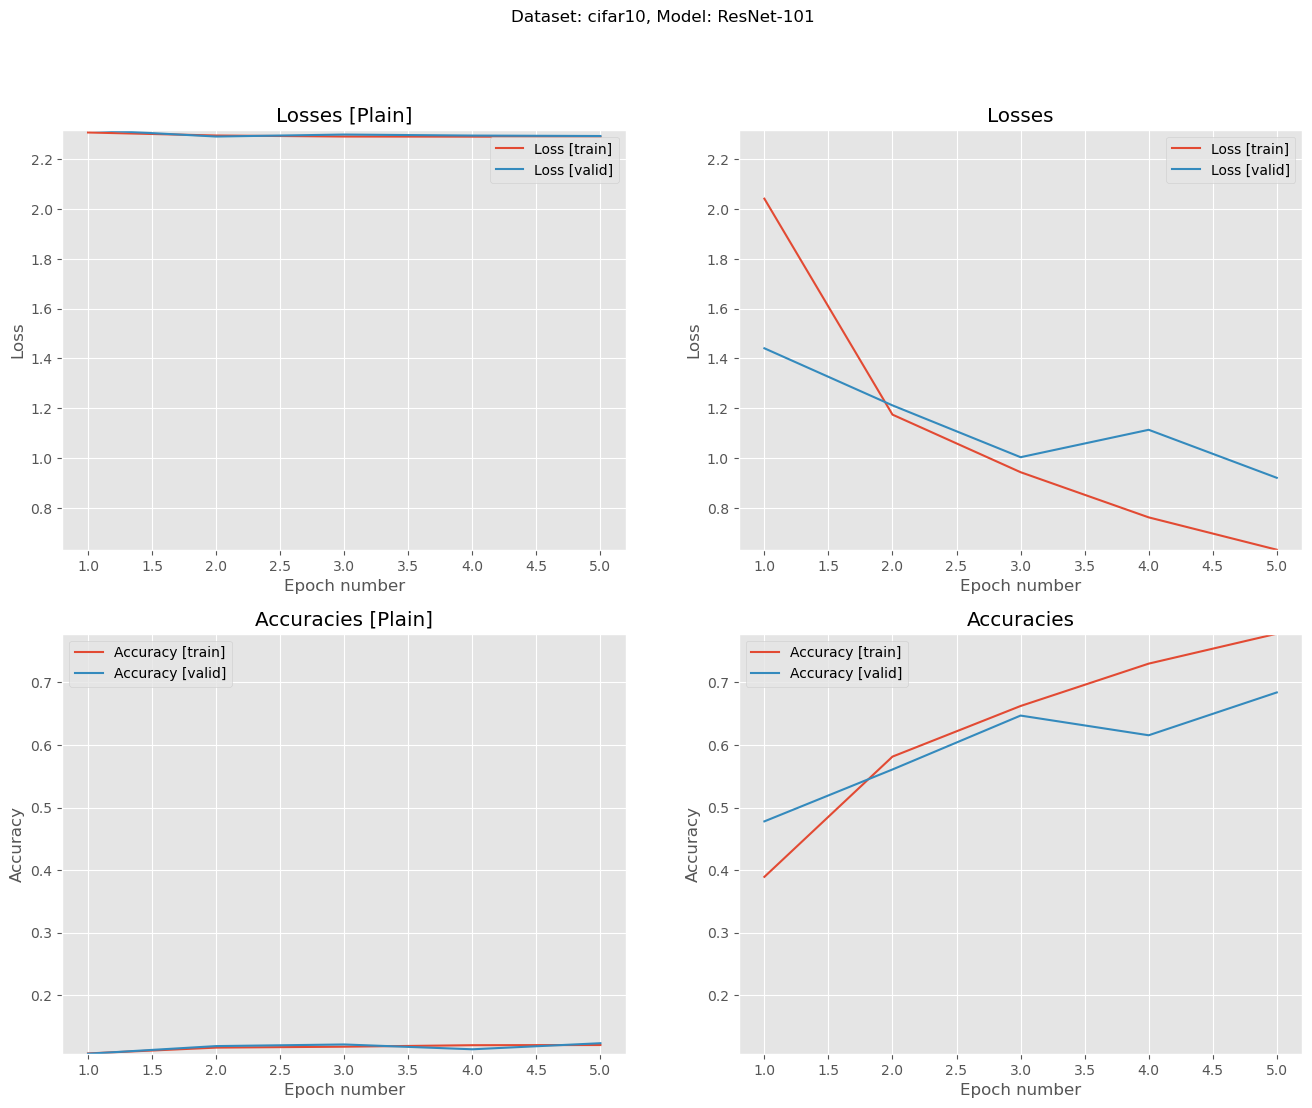

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 10/10 [00:04<00:00,  2.23it/s]


Epoch [1/5], Loss: 4.5698, Accuracy: 0.01518
Epoch [1/5], Loss: 4.5621, Accuracy: 0.0166


100%|██████████| 10/10 [00:04<00:00,  2.24it/s]


Epoch [2/5], Loss: 4.5189, Accuracy: 0.02082
Epoch [2/5], Loss: 4.5164, Accuracy: 0.02


 80%|███████▉  | 39/49 [01:19<00:20,  2.04s/it]


KeyboardInterrupt: 

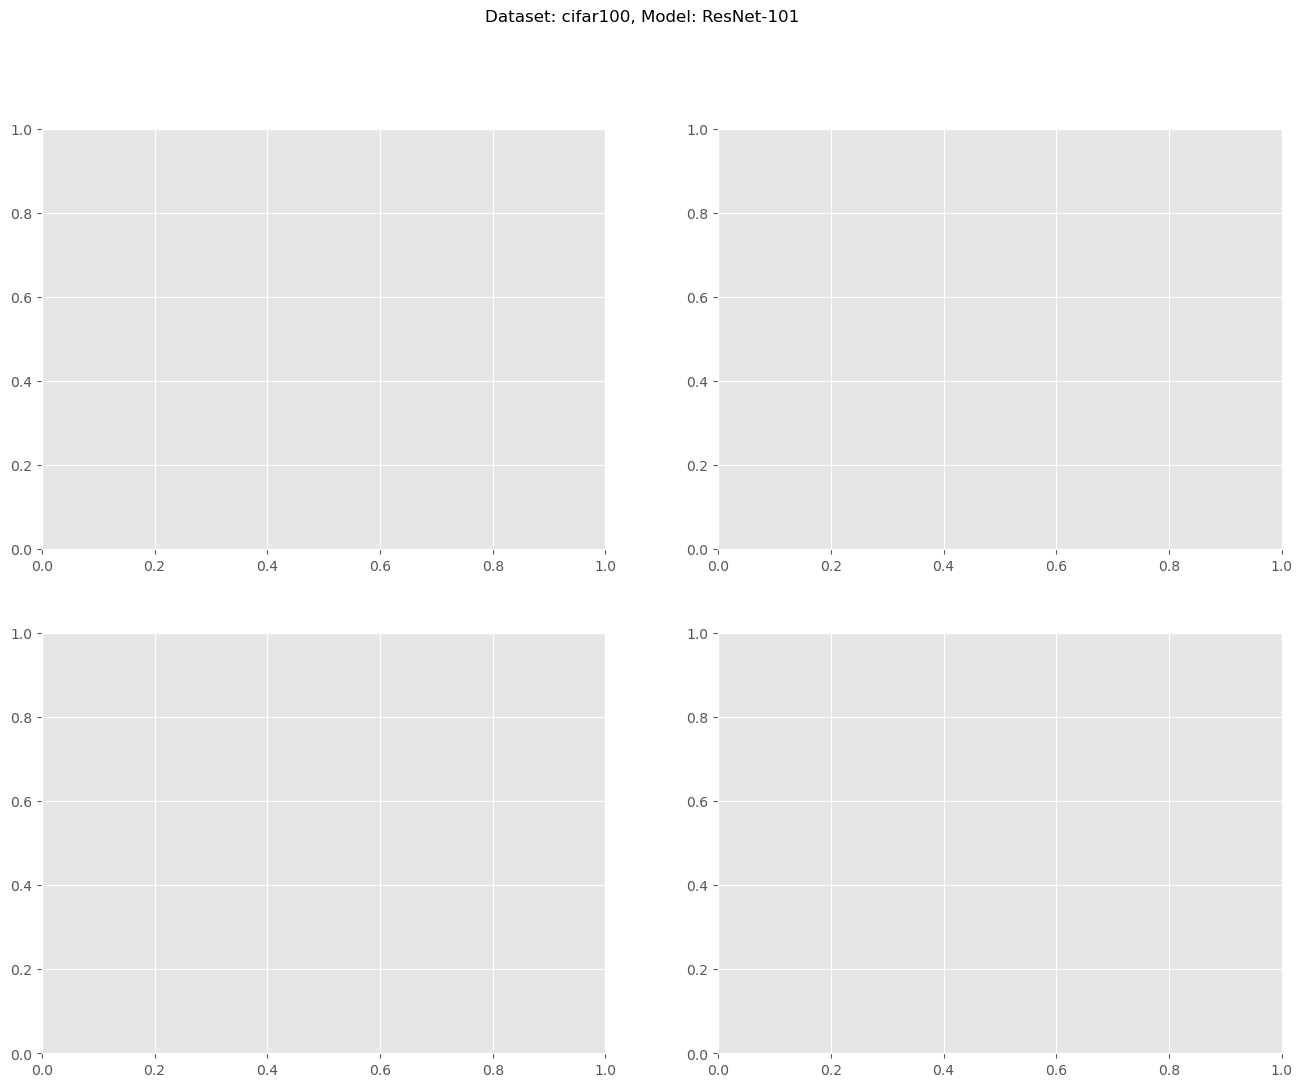

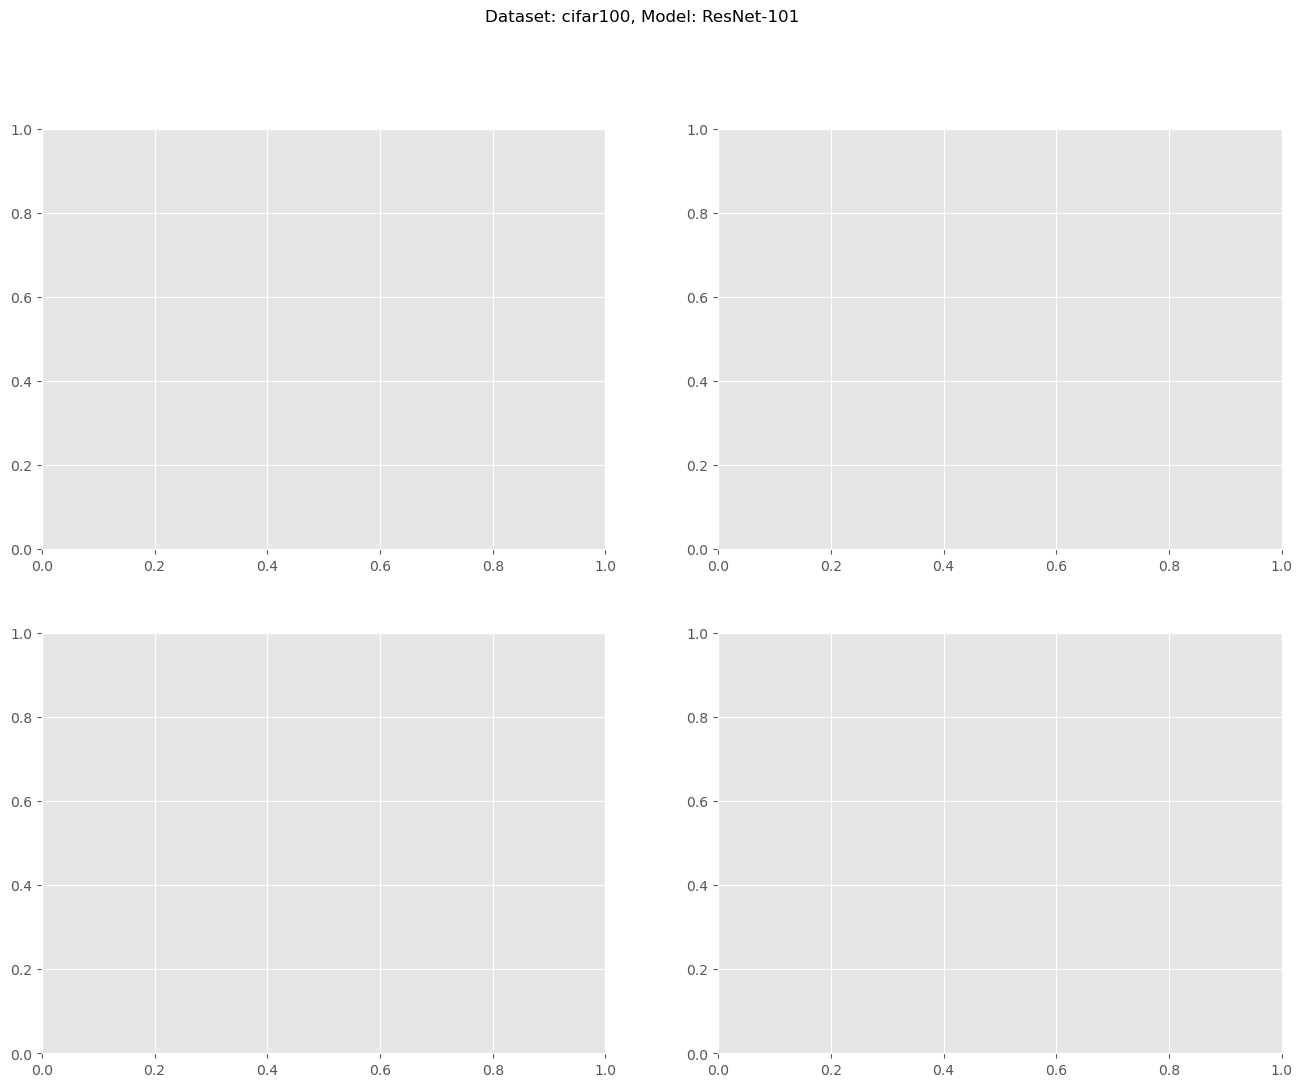

In [5]:
import os
import yaml

import torch.nn as nn
import torch.optim as optim

from src.datasets import cifar100, cifar10, fashion_mnist, mnist

loaders = {}
    
for dataset in [cifar10, cifar100, fashion_mnist, mnist]:
    train_loader, valid_loader = dataset()
    loaders["train"] = train_loader
    loaders["valid"] = valid_loader
    
    if dataset.__name__ in ['cifar100']:
        num_classes = 100
    else:
        num_classes = 10
        
    if dataset.__name__ in ['cifar10', 'cifar100']:
        in_channels = 3
    else:
        in_channels = 1
        
    # for version in [18, 26, 34, 50, 68, 101]:
    for version in [101]:
        fig_diff, axes_diff = plt.subplots(2, 2, figsize=(16, 12))
        fig_diff.suptitle(f"Dataset: {dataset.__name__}, Model: ResNet-{version}")
        
        fig_metric, axes_metric = plt.subplots(2, 2, figsize=(16, 12))
        fig_metric.suptitle(f"Dataset: {dataset.__name__}, Model: ResNet-{version}")
        
        version_path = os.path.join('experiments', EXPERIMENT, dataset.__name__, f"ResNet-{version}")
        
        for plain in [True, False]:
            
            model = resnet(version, in_channels, num_classes, plain)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters())
            scheduler = None # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
            device = torch.device("mps")
            
            DataCollector.reset_instances()
            COLLECTOR = DataCollector(metric_kwargs=COLLECTOR_KWARGS)
            
            losses, accuracies = train(model, loaders, criterion, optimizer, scheduler, NUM_EPOCHS, device)
            
            model_path = os.path.join(version_path, f"Plain: {plain}")
            COLLECTOR.save_state(model_path)
            
            plot_differences(fig_diff, axes_diff, plain, model)            
            plot_metrics(fig_metric, axes_metric, plain, losses, accuracies)
            
            with open(os.path.join(model_path, 'losses.yaml'), 'w+') as f:
                yaml.safe_dump(losses, f)
                
            with open(os.path.join(model_path, 'accuracies.yaml'), 'w+') as f:
                yaml.safe_dump(accuracies, f) 
            
        share_y_axis(fig_diff, axes_diff)
        fig_diff.savefig(os.path.join(version_path, 'Differences.png'))
        share_y_axis(fig_metric, axes_metric)
        fig_metric.savefig(os.path.join(version_path, 'Metrics.png'))
        plt.show()
        plt.close()

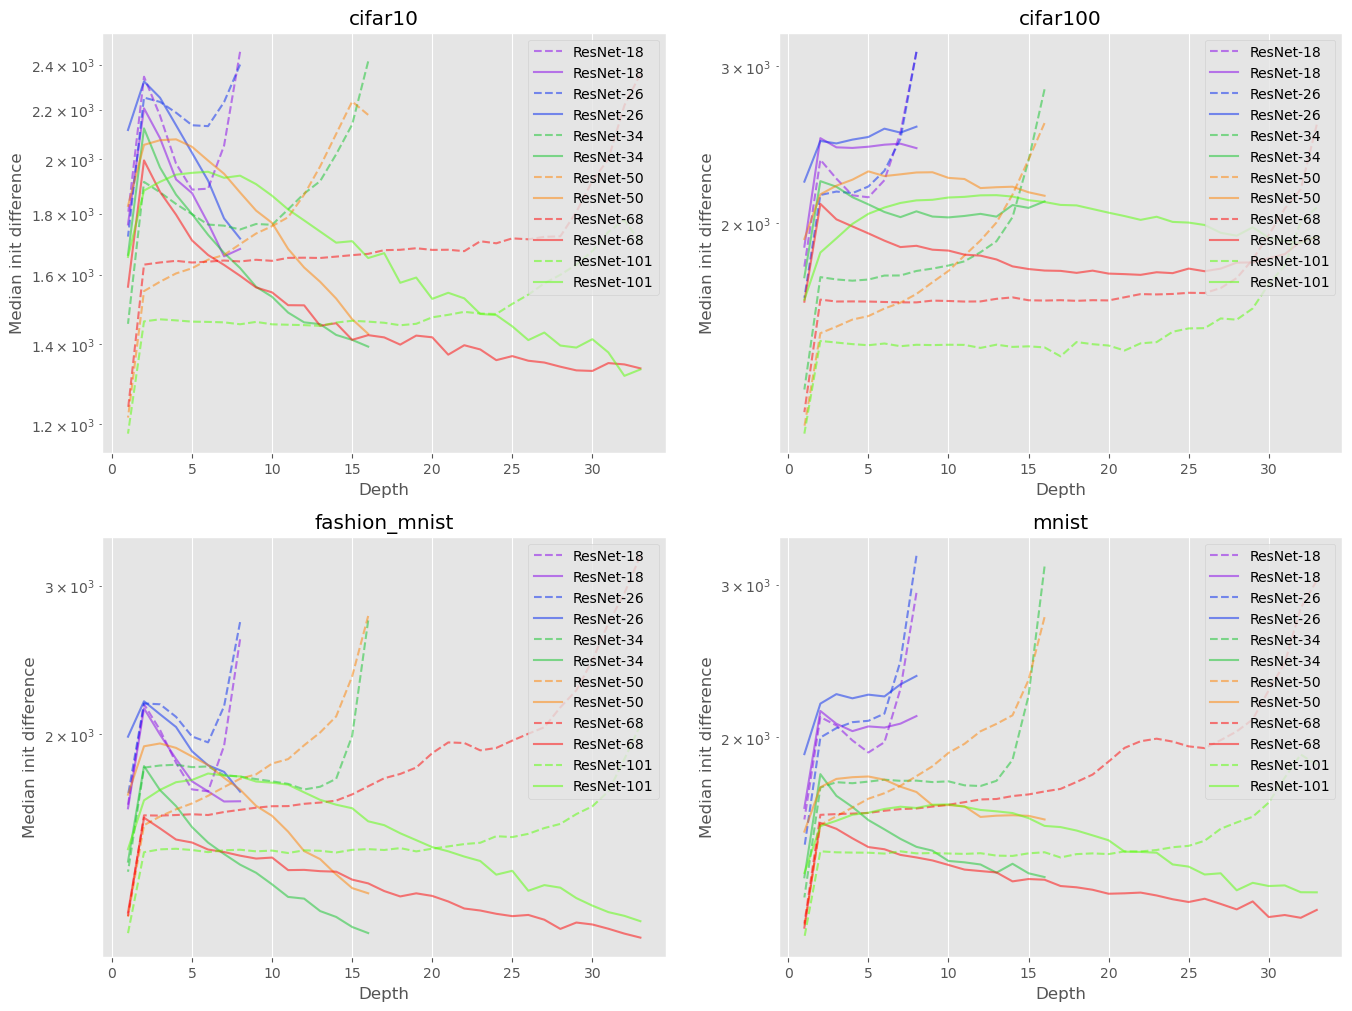

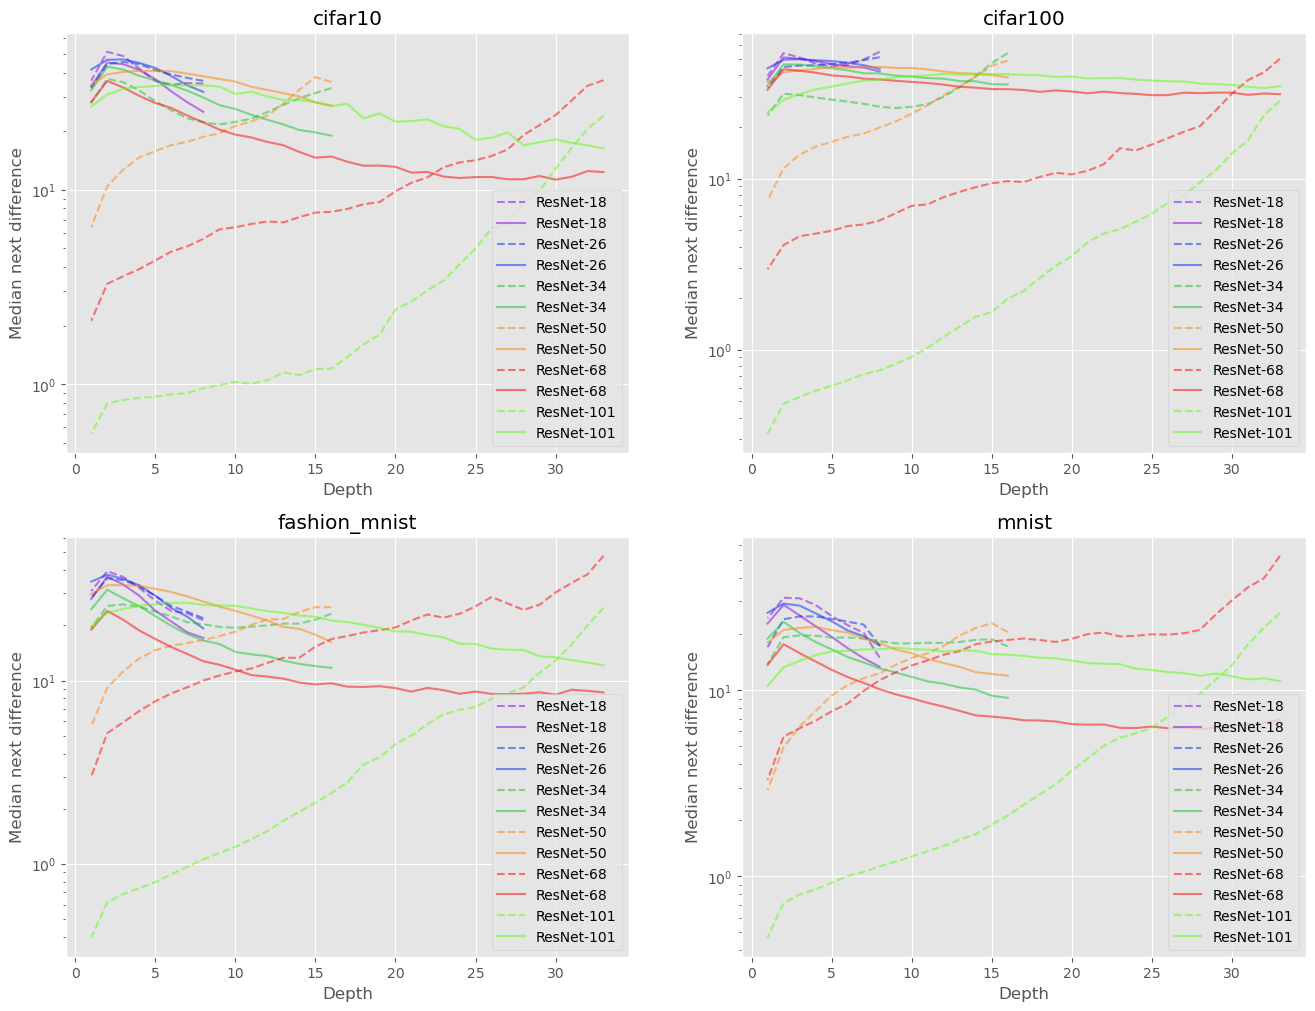

In [ ]:
for diff_type, title in zip(["init", "next"], ['Init differences among datasets', 'Next differences among datasets']):
    fig, axes = plt.subplots(2, 2, figsize=(16,12))
    
    for idx, dataset in enumerate([cifar10, cifar100, fashion_mnist, mnist]):
        array = []
            
        for version in [18, 26, 34, 50, 68, 101]:
            version_path = os.path.join('experiments', EXPERIMENT, dataset.__name__, f"ResNet-{version}")

            for plain in [True, False]:
                DataCollector.reset_instances()
                COLLECTOR = DataCollector(metric_kwargs=COLLECTOR_KWARGS)
                
                model_path = os.path.join(version_path, f"Plain: {plain}")
                try:
                    COLLECTOR.load_state(model_path)
                except Exception:
                    continue
                
                with open(os.path.join(model_path, 'stats.yaml'), 'r') as f:
                    stats = yaml.safe_load(f)
                    
                array.append((version, plain, [], []))
                for depth in stats[diff_type].keys():
                    array[-1][2].append(depth)
                    array[-1][3].append(stats[diff_type][depth]['median'])
        
        row, col = idx // 2, idx % 2
        axes[row][col].set_title(f"{dataset.__name__}")
        for version, plain, depths, means in array:
            if plain:
                axes[row][col].plot(depths, means, label=f"ResNet-{version}", linestyle='--', color=plt.cm.prism(version / 101), alpha=0.5)
            else:
                axes[row][col].plot(depths, means, label=f"ResNet-{version}", color=plt.cm.prism(version / 101), alpha=0.5)
        axes[row][col].set_xlabel('Depth')
        axes[row][col].set_ylabel(f'Median {diff_type} difference')
        axes[row][col].legend()
        axes[row][col].set_yscale('log')
        
    fig.savefig(os.path.join(f"experiments/{EXPERIMENT}", f"Gathered {diff_type} differences.png"))
    plt.show()
    plt.close()

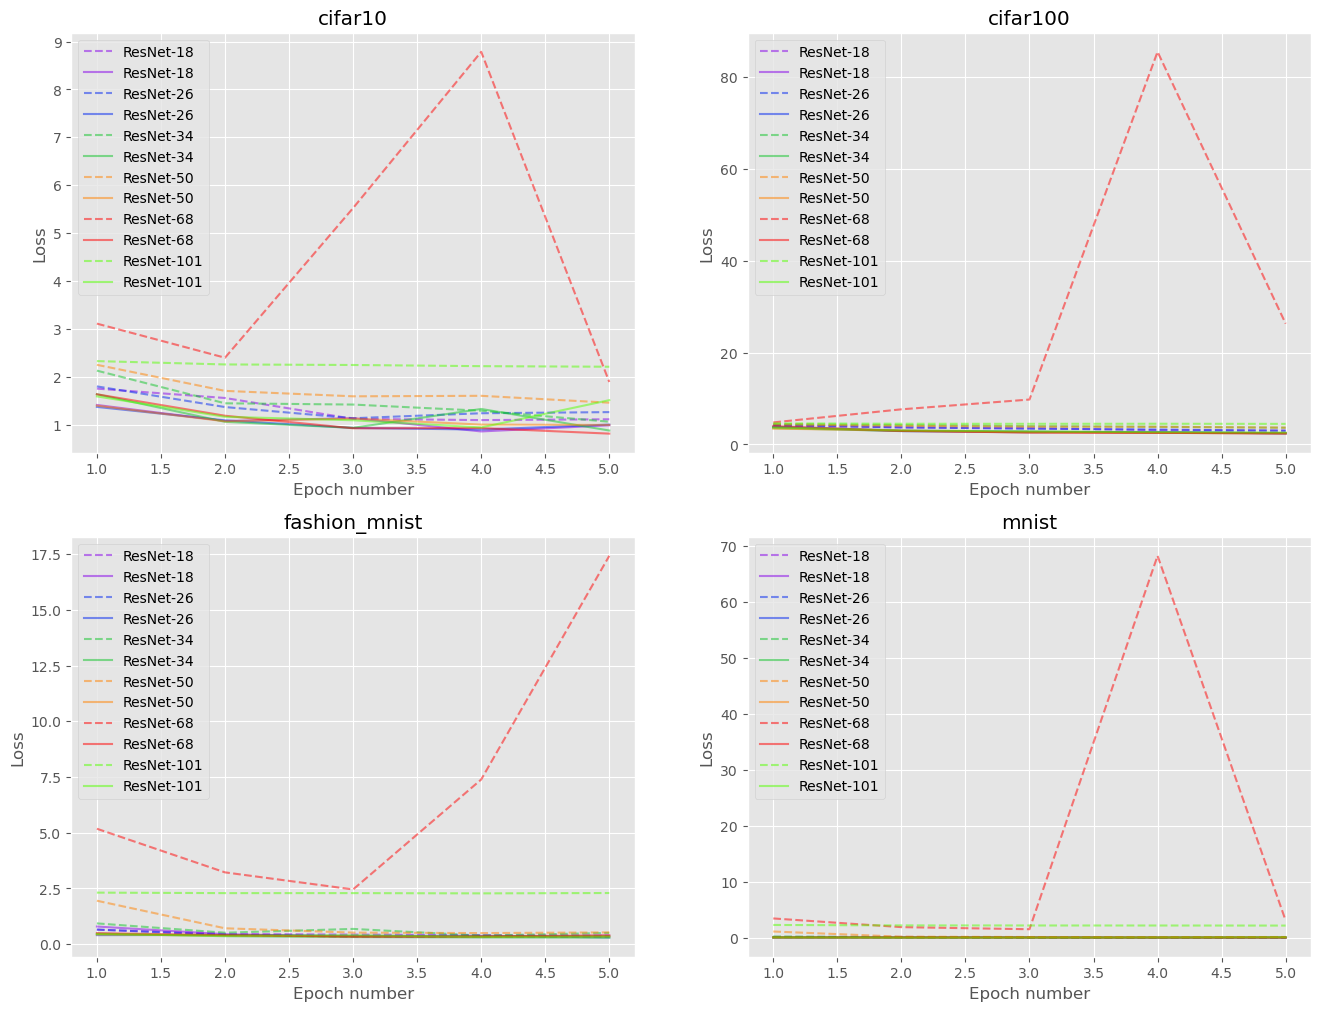

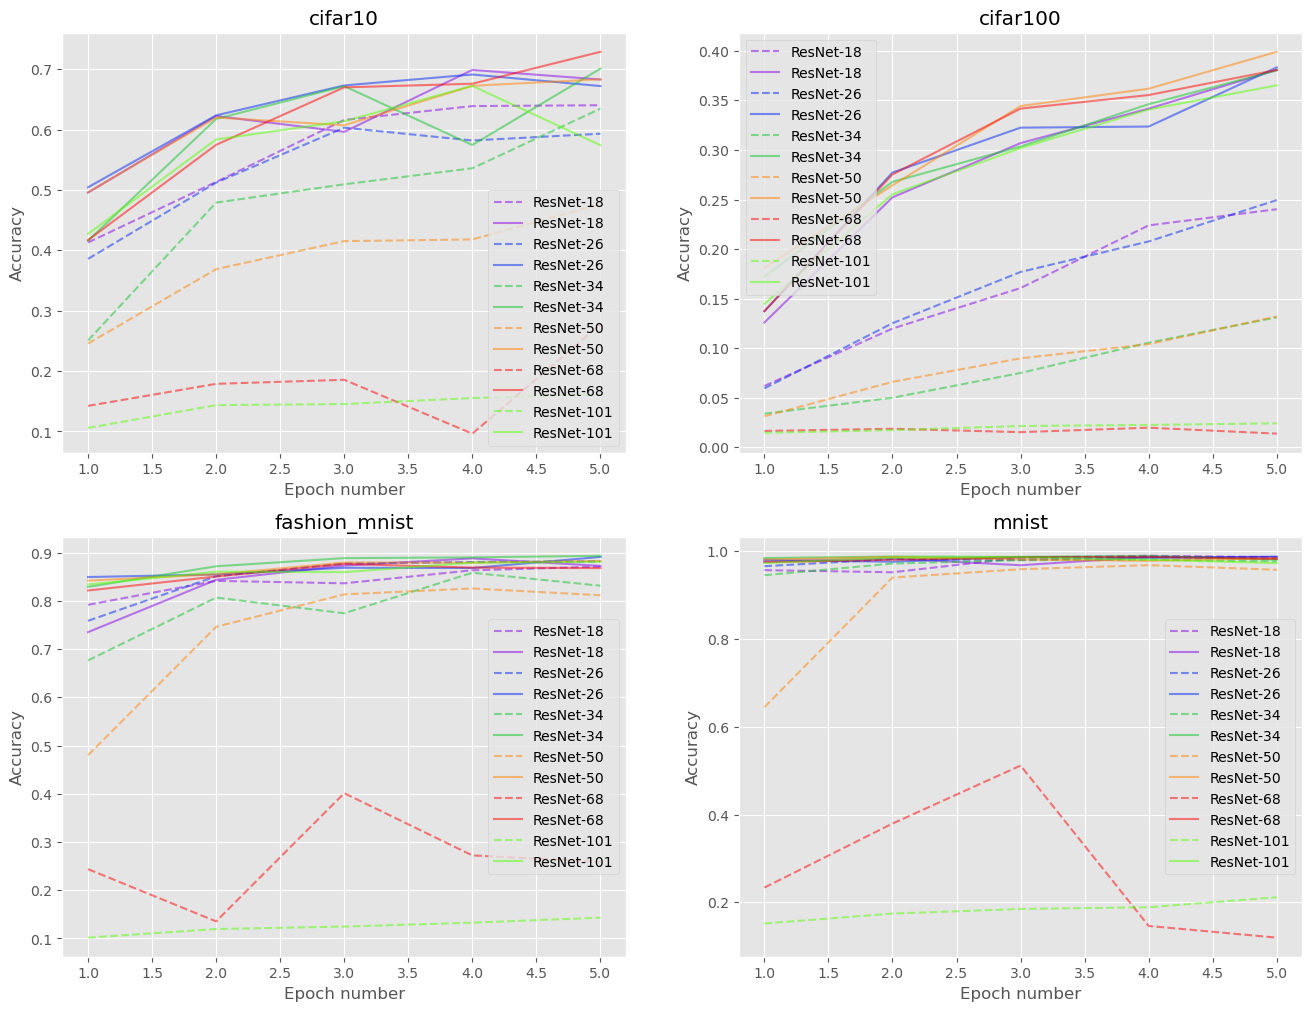

In [ ]:
for eval, title in zip(["losses", "accuracies"], ['Losses [valid]', 'Accuracies [valid]']):
    fig, axes = plt.subplots(2, 2, figsize=(16,12))
    
    for idx, dataset in enumerate([cifar10, cifar100, fashion_mnist, mnist]):
        array = []
            
        for version in [18, 26, 34, 50, 68, 101]:
            version_path = os.path.join('experiments', EXPERIMENT, dataset.__name__, f"ResNet-{version}")

            for plain in [True, False]:
                DataCollector.reset_instances()
                COLLECTOR = DataCollector(metric_kwargs=COLLECTOR_KWARGS)
                
                model_path = os.path.join(version_path, f"Plain: {plain}")
                try:
                    COLLECTOR.load_state(model_path)
                except Exception:
                    continue
                
                with open(os.path.join(model_path, f'{eval}.yaml'), 'r') as f:
                    evals = yaml.safe_load(f)
                    
                array.append([version, plain, [], []])
                array[-1][2] = evals['train']
                array[-1][3] = evals['valid']
        
        row, col = idx // 2, idx % 2
        axes[row][col].set_title(f"{dataset.__name__}")
        for version, plain, train, valid in array:
            if plain:
                axes[row][col].plot(range(1, len(train) + 1), valid, label=f"ResNet-{version}", linestyle='--', color=plt.cm.prism(version / 101), alpha=0.5)
            else:
                axes[row][col].plot(range(1, len(train) + 1), valid, label=f"ResNet-{version}", color=plt.cm.prism(version / 101), alpha=0.5)
        axes[row][col].set_xlabel('Epoch number')
        axes[row][col].set_ylabel("Loss" if eval == "losses" else "Accuracy")
        axes[row][col].legend()
        
    fig.savefig(os.path.join(f"experiments/{EXPERIMENT}", f"Gathered {eval}.png"))
    plt.show()
    plt.close()